In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti']

In [3]:
model_n = 0
task_list = ['fdgo', 'fdanti', 'delaygo', 'delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = '4_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','figure3')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [5]:
def plot_N3D(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(c_list, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)
        
def plot_FP_jitter_3D(m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,qvals,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,unstable_qlim = -6,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#         for fp_ind in fp_inds:
#             for jit in range(n_jit):
#                 h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
#                 h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
#                 jitter = np.dot(h_t,D_use)
#                 ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)
                
        
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 3)


In [6]:
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

fp_epoch = 'stim1'
ind = -1
T_inds = get_T_inds(trial_all[task_list[0]],fp_epoch)
B,N = np.shape(h_all[task_list[0]][T_inds[ind],:,:])
R = np.zeros((len(task_list)*B*len(T_inds),N))
Y = np.zeros((7,len(task_list)*B*len(T_inds)))

for rule_i in range(len(task_list)):
    rule = task_list[rule_i]
    T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
    r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
    
    isanti = 'anti' in task_list[rule_i]
    ismemory = 'delay' in task_list[rule_i]
    y_anti = isanti*np.ones((np.shape(r)[0],1))
    y_memory = ismemory*np.ones((np.shape(r)[0],1))
    y_stim = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
    y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
    
    inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
    
    R[inds,:] = r
    Y[0,inds] = np.expand_dims(isanti,axis = 0)
    Y[1,inds] = np.expand_dims(ismemory,axis = 0)
    Y[2,inds] = np.expand_dims(np.sin(y_stim),axis = 0)
    Y[3,inds] = np.expand_dims(np.cos(y_stim),axis = 0)
    Y[4,inds] = np.expand_dims(np.sin(y_out),axis = 0)
    Y[5,inds] = np.expand_dims(np.cos(y_out),axis = 0)
    Y[6,inds] = np.repeat(T_inds,B)
    
    Y_labels = ['ANTI v. Pro','MEMORY v. DELAY','STIM '+ r' $\cos{\theta}$','STIM '+ r' $\sin{\theta}$',
                'OUT '+ r' $\cos{\theta}$','OUT '+ r' $\sin{\theta}$','TIME']
    
lm = linear_model.LinearRegression()
model = lm.fit(Y.T,R)
Beta = model.coef_
Beta_qr,_ = LA.qr(Beta)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [7]:
def make_FP_axs(f,m_all,rule_in,fp_epoch,n_fps = 5,axs ='pca', clust = 'False'):
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']

    if (clust == 'True') & (len(sorted_fps)>2):
        kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
        _,fp_inds = np.unique(kmeans.labels_,return_index=True)
    
    else:
        fp_inds = range(len(sorted_fps))
        
    if axs == 'tdr':
        D_use = make_axes(m_all,rule_in,fp_epoch)
    elif axs =='pca':
        pca = PCA(n_components = 3)
        fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
        D_use = pca.components_.T
    elif axs =='pca_h':
        trial = gen_trials_from_model_dir(m_all,rule_in,mode='random',noise_on = False)
        X, _ = gen_X_from_model_dir_epoch(m_all,trial,fp_epoch)
        pca = PCA(n_components = 3)
        fp_pca = pca.fit_transform(X.T)
        D_use = pca.components_.T
    elif axs =='out':
        w_in, b_in, w_out, b_out = get_model_params(m_all)
        D_use = w_out[:,1:]

    return D_use, fp_inds, sorted_fps

In [8]:
from tools_lnd import comp_eig_decomp
from itertools import compress 

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


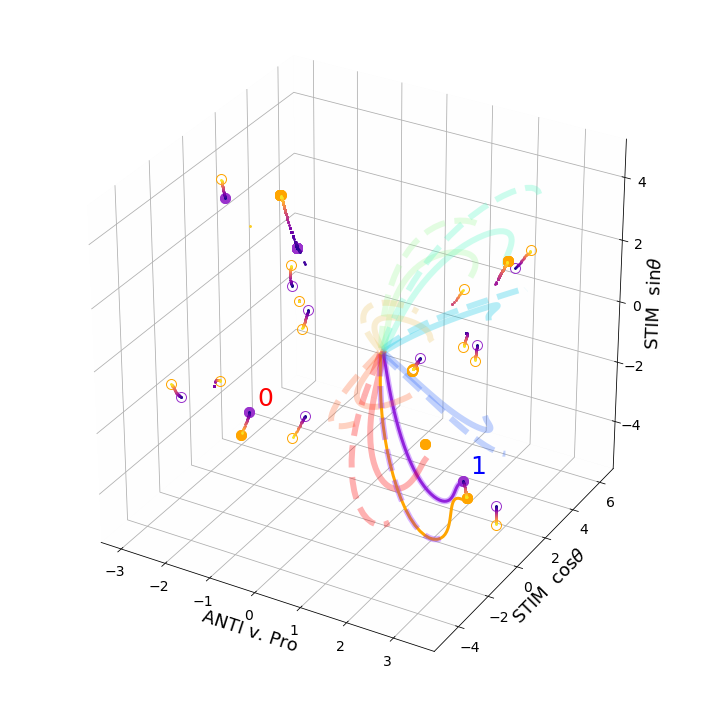

In [9]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')



offset = 0
t_set = [0+offset, 0+offset]
ind_stim_loc = t_set[0]

if ind_stim_loc == 0:
    trial_num = [0,0]
else:
    trial_num = [int(80*ind_stim_loc/360),int(80*ind_stim_loc/360)]
    
    
trial_set = range(0,80,10)
rule_set = [task_list[0],task_list[2]]
epoch_set = ['stim1',]
step_file = 'interp_tasks'
linestyle = ['-','--']
n_interp = 20
if t_set[1]==0:
    s_set_colors = ['r','b']
    s_label = [0,1]
    si_use = [0,2]
else:
    s_set_colors = ['b','r']#anti
    s_label = [1,0]
    si_use = [1,2]
    

trial_str = '_'.join(str(t) for t in t_set)
rule_str = '_'.join(str(r) for r in rule_set)

ei = 0
epoch = epoch_set[ei]

# rule_axs = 0
# axs = 'pca_h'
# f = os.path.join(m,'tf_fixed_pts_all_init',rule_set[rule_axs],epoch+'_'+str(t_set[rule_axs])+'.0.npz')
# D_use,_,_ = make_FP_axs(f,m,rule_set[rule_axs],epoch,axs =axs, clust = 'False')
# axes_label1 = 'pca_1'
# axes_label2 = 'pca_2'
# axes_label3 = 'pca_3'

use_yinds = [0,2,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
axes_label3 = Y_labels[use_yinds[2]]
D_use = Beta_qr[:,use_yinds]

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']
ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(len(rule_set)):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#     ax = plt.subplot(111)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
    
    if ri==0:
        for si in range(len(si_use)):
            s = np.argsort(qvals)[si_use[si]]
            ax.text(fp_project[s,0],fp_project[s,1]+.5,fp_project[s,2], str(s_label[si]), 
                    color=s_set_colors[si],fontsize = 25)

    if ri<2:
        plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
               rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
                   n_jit = 100,unstable_qlim = -10,c = cmap_discrete[ri])
    
#     stable_fp = np.log10(qvals)<-10
#     ax.plot3D(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],fp_project[stable_fp==1,2],
#              'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 2)
#     ax.plot3D(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],fp_project[stable_fp==0,2],
#              'o',c = cmap_discrete[ri],markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 2)
    
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
#     c_list = trial.y_loc[-1,:]
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
#     c_list = cmap_discrete[ri]
#     highlight_trial = [trial_num[0],]
#     plot_N3D(x_epoch[highlight_trial,:,:],D_use.T,c_list,linewidth = 3, linestyle = '-',alpha = 1)

    for step_i in range(20):
        f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_step_'+str(step_i)#'_'+str(t_set[1])
        filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']

        fp_project = np.dot(step_fps,D_use)
        ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))
#         plt.show()

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
# plt3D.title(tit,fontsize = 18)
ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [10]:
os.path.join(figpath,step_file,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_tasks/X TASK stim1 fdgo vs.delaygo_interp_tasks_0.pdf'

In [11]:
def plot_fp_struct_multicolor(m,tasks,trial_set,D,fp_epoch,sorted_fps,eig_decomps,q_star,do_plot_FP = 1,
                              t_num = 0,qlim = .000001,color_label = 'stim1',alpha_color = 'white',fs = 18):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': fs})
    lw = 3
    al = .6

    ## plot w test set of trials
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        for rule_ind in tasks:
            rule = rules_dict['all'][rule_ind]
            trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
            T,S,N = np.shape(h_tf)
            
            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
            stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
            y_loc = trial.y_loc[-1,:]
            
            if color_label == 'stim1' or color_label == 'delay1':
                c_inds = stim1_locs
            elif color_label == 'stim2' or color_label == 'delay2':
                c_inds = stim2_locs
            else:
                c_inds = y_loc
            
            if do_plot_FP==0:
                for s in trial_set:
                    c = cmap(c_inds[s]/(2*np.pi))
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    if alpha_color == 'black':
                        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = 'k', alpha = .3, linewidth = lw)
                        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = 'k', alpha = .3, linewidth = lw)
                    
                    if s==t_num:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,label = rule)
                    else:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                    
            elif do_plot_FP==1:
                
                c = 'gray'
                for s in trial_set:
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                
                c = cmap(c_inds[t_num]/(2*np.pi))
                X_trial = np.dot(h_tf[T_inds,t_num,:],D)
                plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw ,label = rule)

                plot_FP(sorted_fps, D.T, eig_decomps,q_star, c)
                
            elif do_plot_FP==2:
                
                for s in range(0,S,int(S/8)):
                    filename = f_list[s]

                    if os.path.exists(filename):
                        print(filename)
                        fp_struct = np.load(filename)
                        c = cmap(c_inds[s]/(2*np.pi))
                        if fp_struct['trial_num']%4==0:

                            X_trial = np.dot(h_tf[T_inds,fp_struct['trial_num'],:],D)
                            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                            if s==0:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, 
                                         linewidth = lw, label = rule)
                            else:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

                            plot_FP(sorted_fps, D.T, eig_decomps,q_star,c)

#             plt.xlabel(r + ' Beta_' + axes_epoch + ' cos@')
#             plt.ylabel(r + ' Beta_' + axes_epoch + ' sin@')
            if fp_epoch=='fix1':
                plt.title(rule_set_names[rule_ind] + ' Context')
            elif fp_epoch=='stim1':
                plt.title(rule_set_names[rule_ind] + ' Stimulus')
            elif fp_epoch=='delay1':
                plt.title(rule_set_names[rule_ind] + ' Memory')
            elif fp_epoch=='go1':
                plt.title(rule_set_names[rule_ind] + ' Response')

In [12]:
def plot_FP_specific(s,X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    lf = 1000
    rf = 1000
    
    X_trial = np.dot(X[s,:],D.T)
        
    n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
    if len(n_arg)>0:
        for arg in range(np.max(n_arg)):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)

    n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
    if len(n_arg)>0:
        for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)

    plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = 'none', markeredgecolor = c, 
             markersize = 20, alpha = .5)

In [13]:
def plot_FP(X, D, eig_decomps, qvals, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = 7
    rf = 7
    
    for s in range(S):
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2], c = c ,alpha = .2,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .2,linewidth = .5)

        if np.log10(qvals[s])>-11:
            mfc = 'None'
        else:
            mfc = c
                
            
        plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = mfc, markeredgecolor = c, markersize = 10, alpha = .5)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


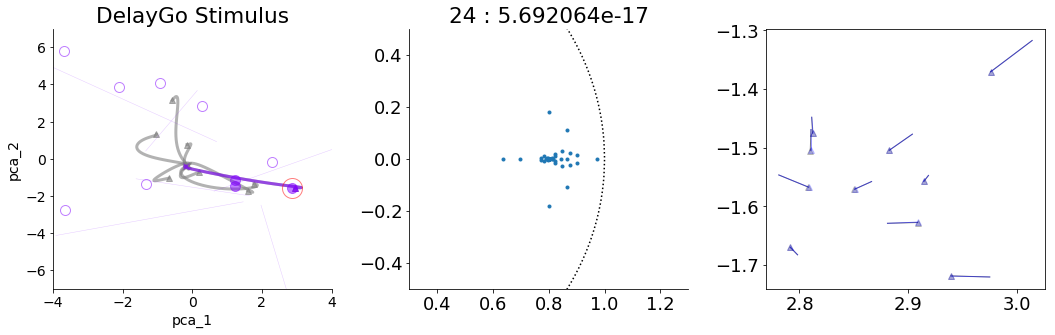

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


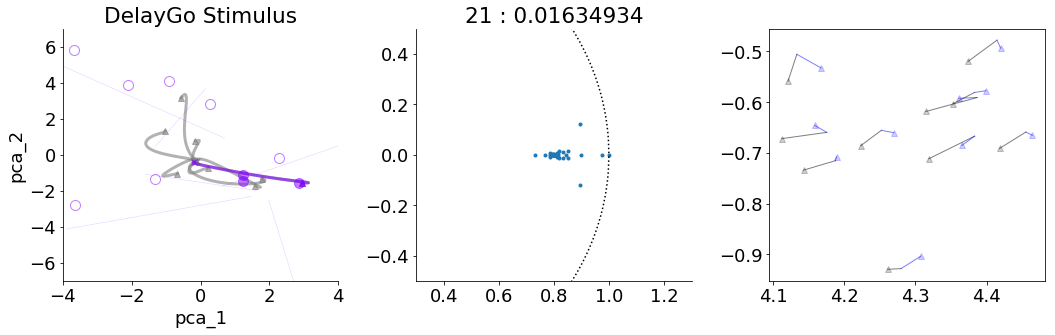

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


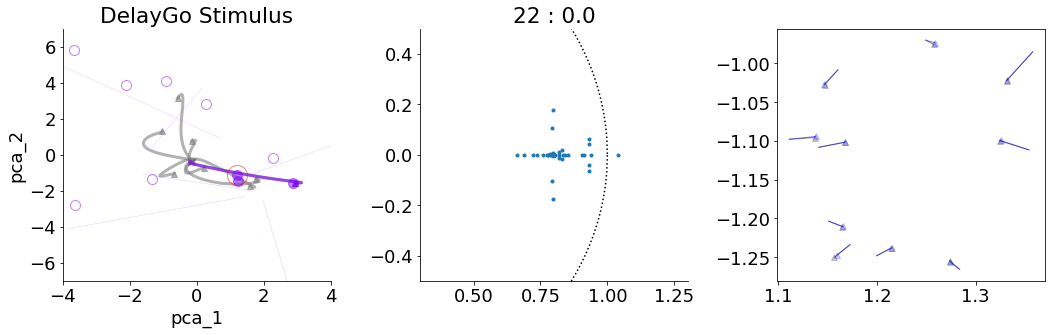

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


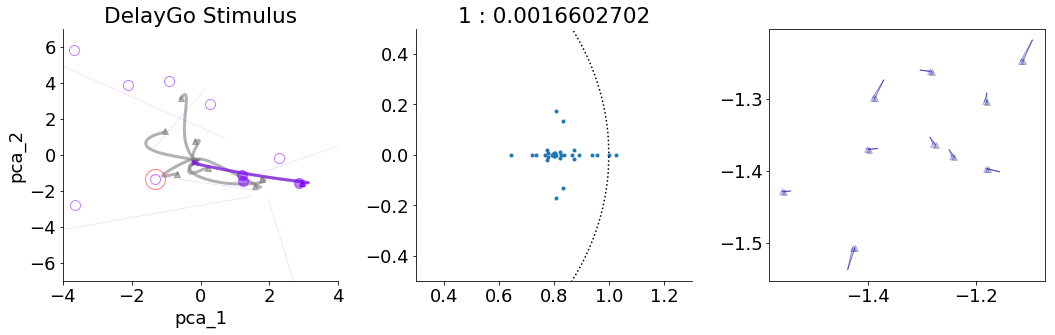

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


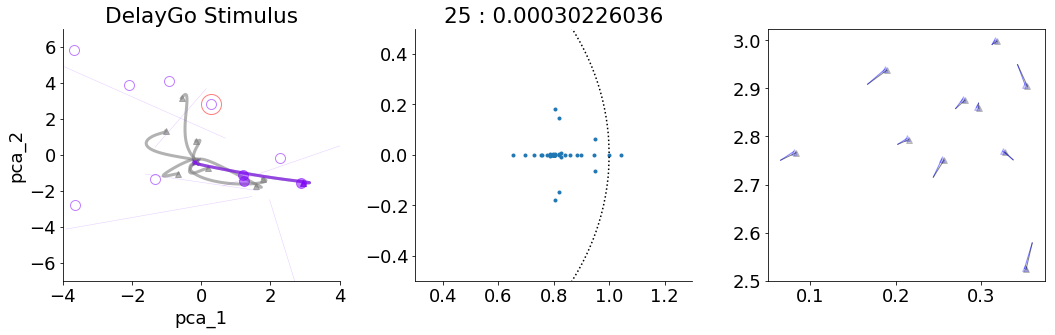

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


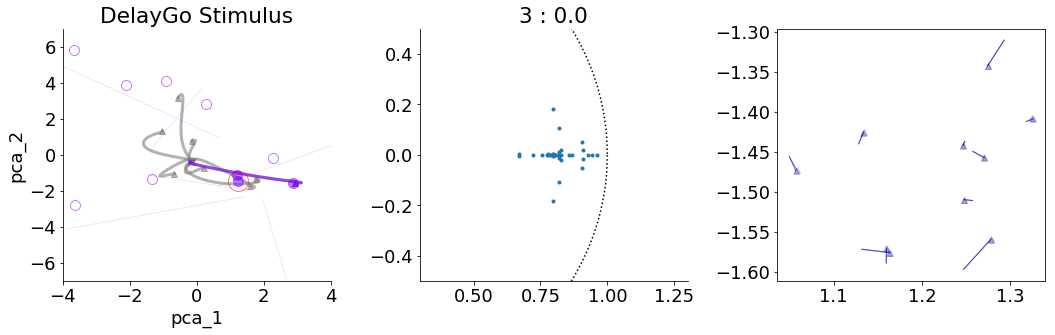

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


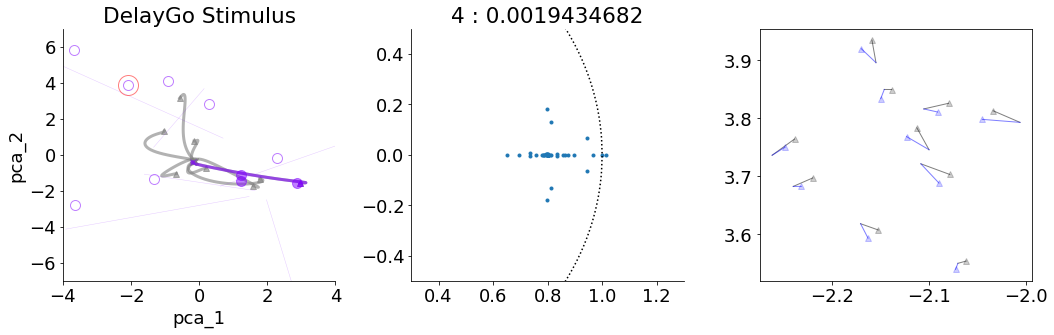

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


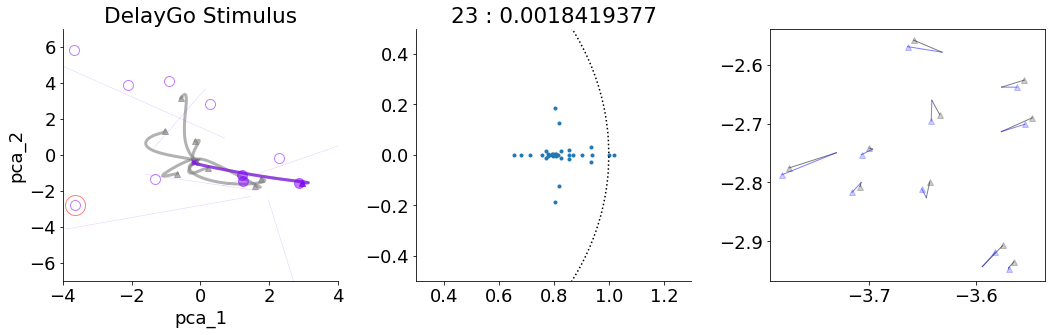

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


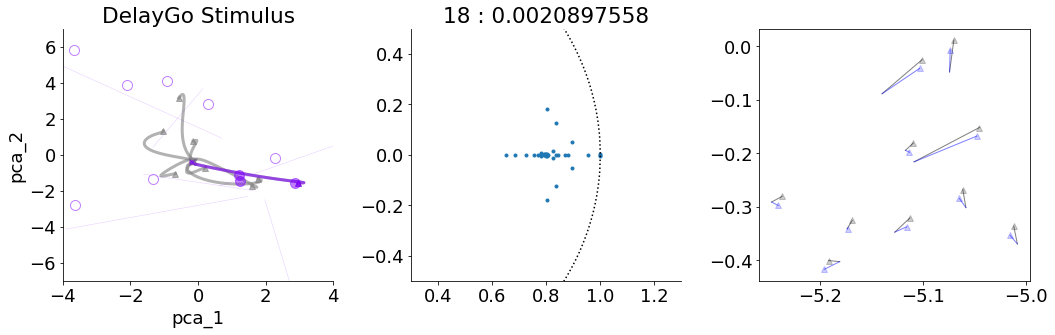

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


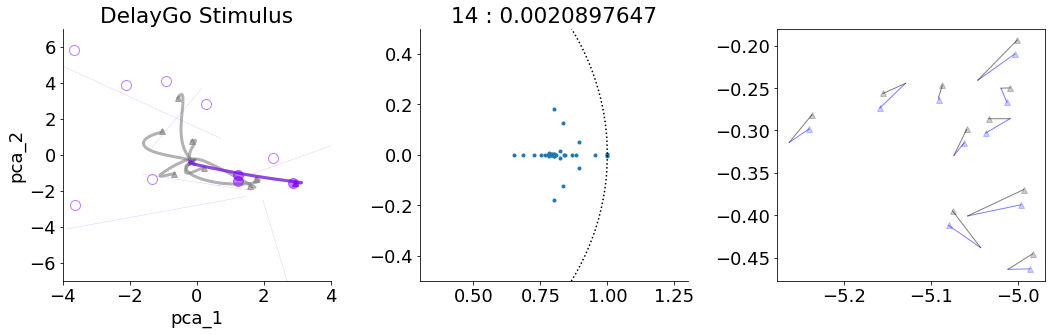

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


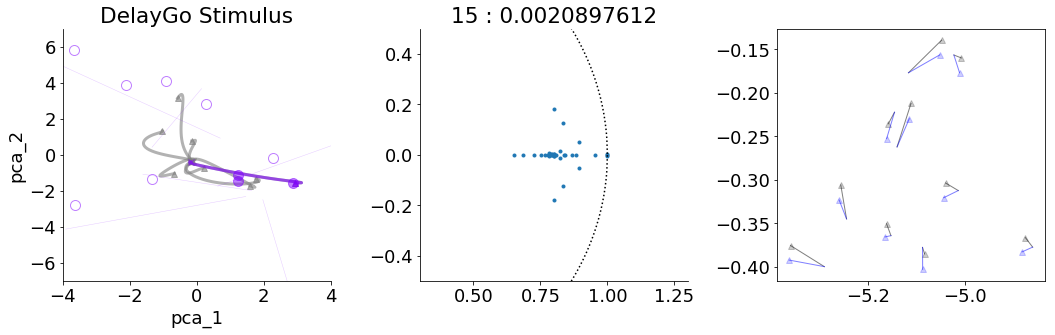

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


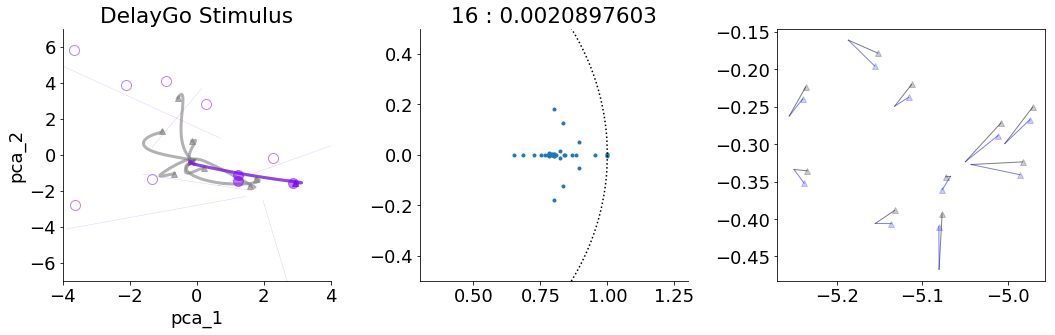

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


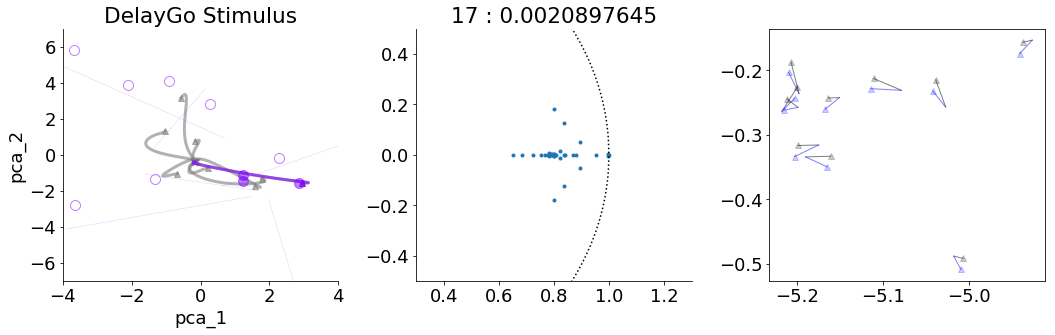

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


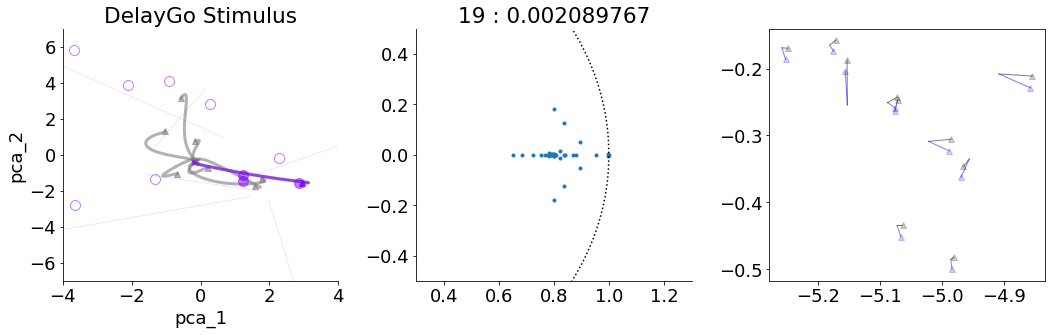

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


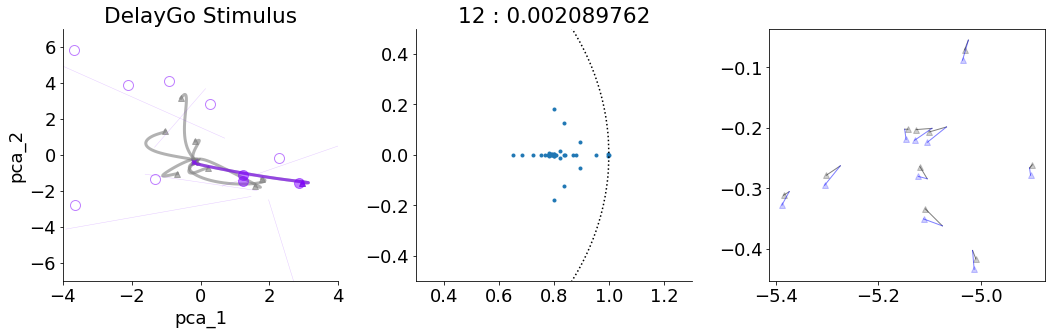

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


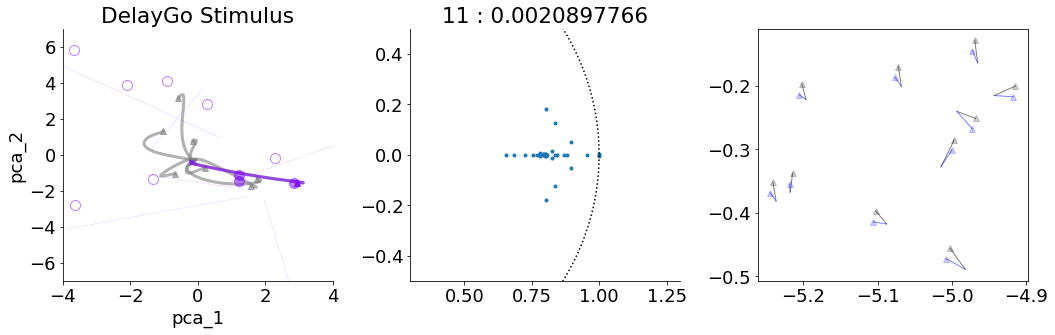

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


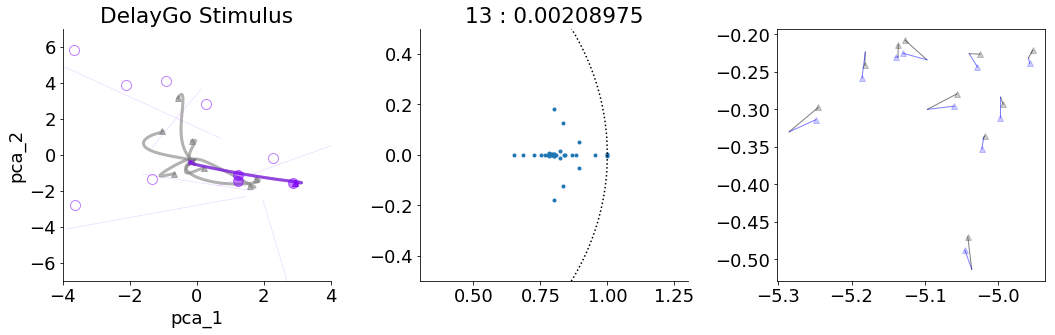

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


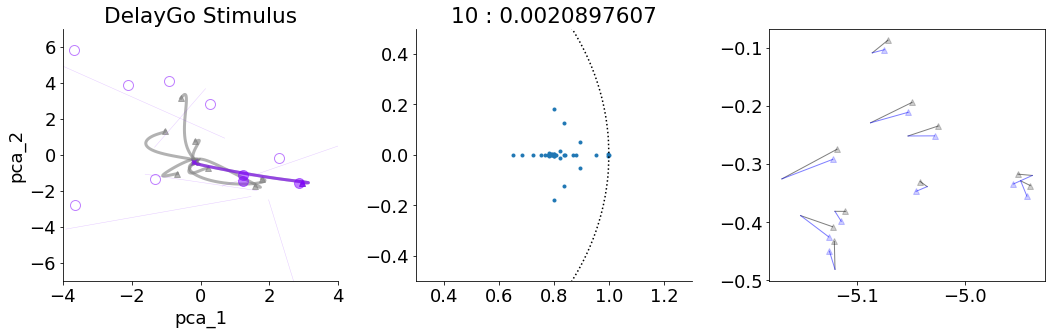

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


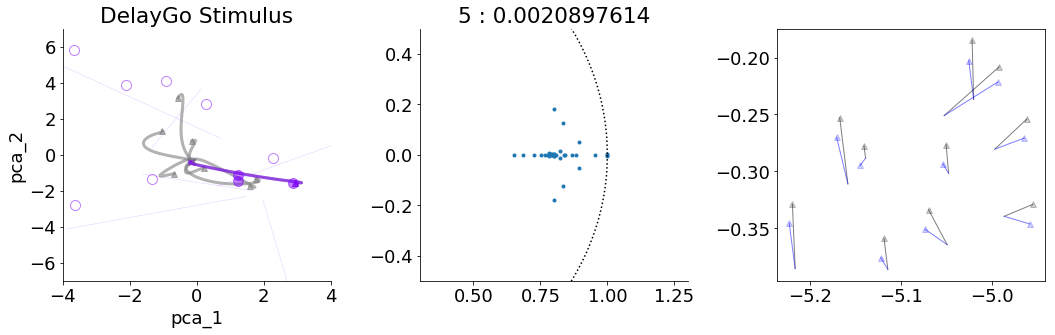

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


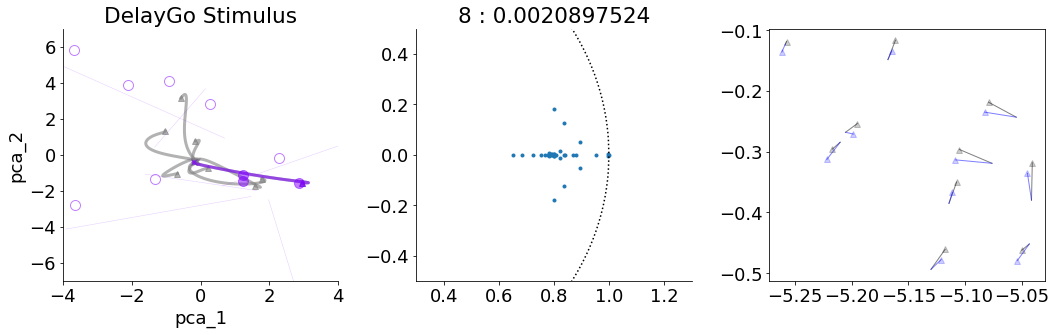

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


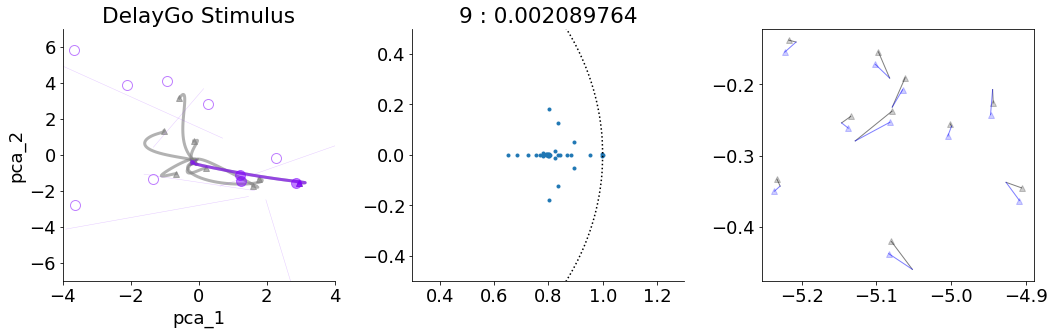

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


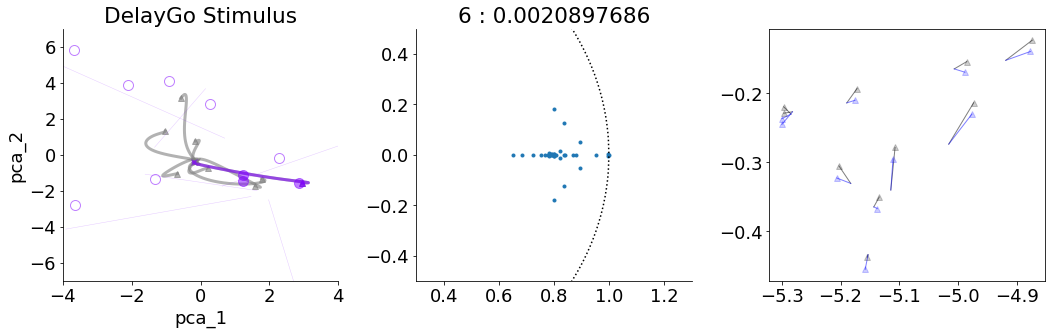

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


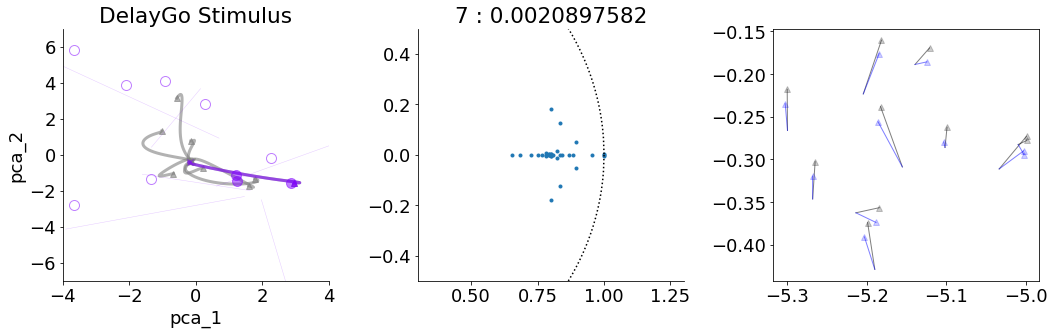

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


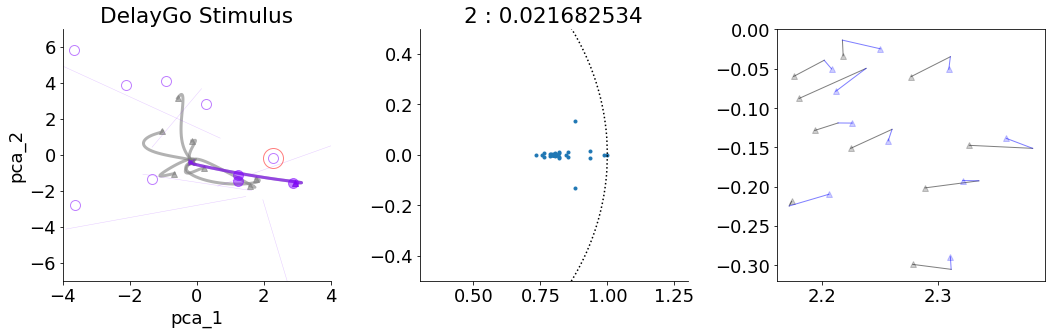

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


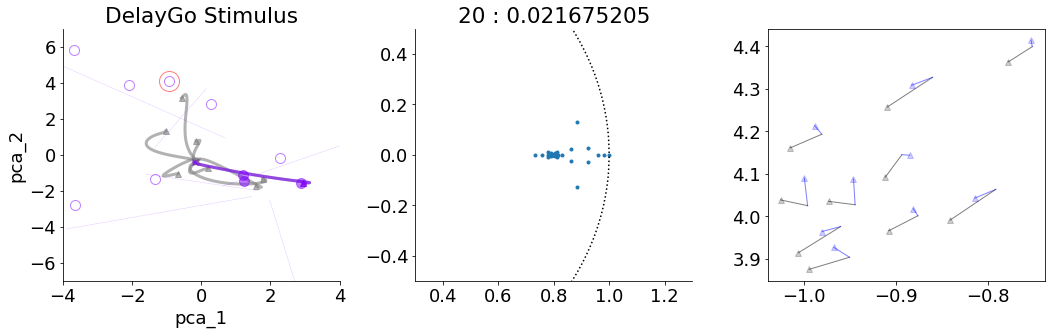

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


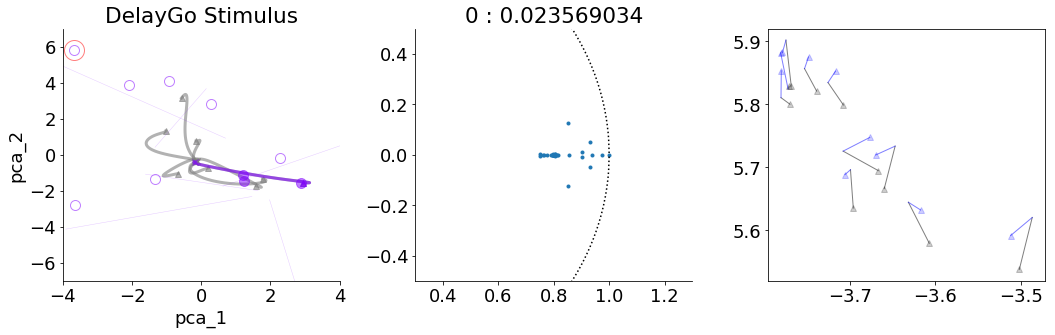

In [14]:
al = .8
lw = 1
t_num = 0
fp_epoch = 'stim1'
qlim = 1
rule_ind = 0
rule_master = rules_dict['all'][rule_ind]
rand_step_coef = 0.1

# use_yinds = [0,3]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]
# D_use = Beta_qr[:,use_yinds]

axs = 'pca'
rule_axs = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule_set[rule_axs],epoch+'_'+str(t_set[rule_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule_set[rule_axs],epoch,axs =axs, clust = 'False')
axes_label1 = 'pca_1'
axes_label2 = 'pca_2'
axes_label3 = 'pca_3'

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
T_inds = get_T_inds(trial,fp_epoch)
_, x = gen_X_from_model_dir(m,trial,d = [])
h_tf = x[:,t_num,T_inds[-1]]

f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,fp_epoch+'_'+str(0)+'.0.npz')
fp_struct = np.load(f)
# fp_inds = np.argsort(fp_struct['qstar'])
fp_inds = np.argsort([LA.norm(fp_struct['xstar'][s,:] - h_tf) for s in range(len(fp_struct['qstar']))])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])
q_star = fp_struct['qstar'][:]

xs = np.linspace(-1, 1, 1000)
ys = np.sqrt(1 - xs**2)

for s in fp_inds:
    fig = plt.figure(figsize=(15,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,3,1)
    plot_fp_struct_multicolor(m,[rule_ind],trial_set,D_use,fp_epoch,sorted_fps,eig_decomps,q_star,
                              do_plot_FP=1,t_num = t_num,qlim = qlim)
    plot_FP_specific(s,sorted_fps, D_use.T, eig_decomps, c = 'r') 
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    
    ax = plt.subplot(1,3,2)
    
#     plt.plot([1,1],[-.1,.1],':k')
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.')
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title(str(s)+ ' : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = 5
    ax = plt.subplot(1,3,3)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
    for jit in range(10):
        del_h = rand_step_coef*npr.randn(N)
        h0 = sorted_fps[s,:] + del_h
        
        #nonlinear system
        h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^k',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-k',linewidth = 1,alpha = .5)
        
        #linear system
        h1 = sorted_fps[s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h0[np.newaxis,:],h1[np.newaxis,:]),axis = 0)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^b',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-b',linewidth = 1,alpha = .5)

    plt.show()

In [17]:
use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

In [22]:
def plot_FP(X, D, eig_decomps, c='k'):

    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = 7
    rf = 7
    D = D[:2,:] #reduce dim in >2
    
    for s in range(S):
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2], c = c ,alpha = .2,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .2,linewidth = .5)

        if np.max(eig_decomps[s]['evals'].real)<1:
            markerfacecolor = c
        else:
            markerfacecolor = 'None'
            
        plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = markerfacecolor, markeredgecolor = c, markersize = 10, alpha = .5)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

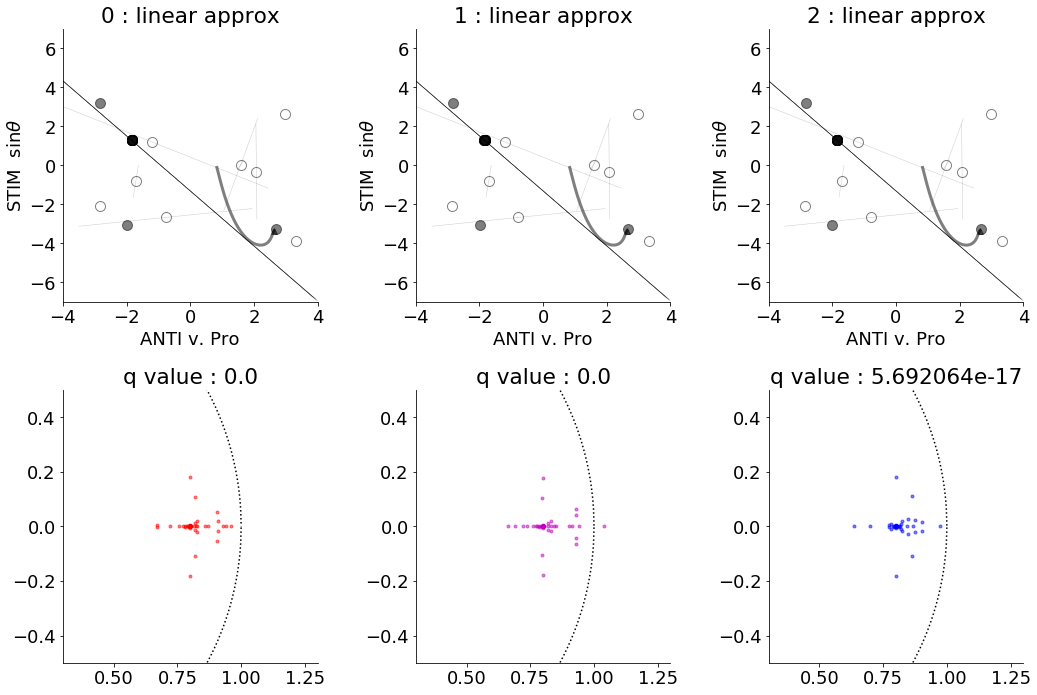

In [28]:
cmap = plt.get_cmap('rainbow')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)
epoch = 'stim1'
trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
T_inds = get_T_inds(trial,epoch)
_, h_full = gen_X_from_model_dir(m,trial,d = [])
h0 = h_full[:,t_num,T_inds[0]]
x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],len(T_inds),1)
# s_set = [24,15,29]#delaygo
s_set = [3,22,24]#fdgo
color_set = ['r', 'm', 'b']
s_set = np.argsort(q_star)[:3]
t_num = 0

fig = plt.figure(figsize=(15,10),tight_layout=True,facecolor='white')
for si in range(len(s_set)):
    s = s_set[si]
    c = color_set[si]
    
    ax = plt.subplot(2,len(s_set),si+1+len(s_set))
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c=c,alpha = .5)
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title('q value : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = len(T_inds)
    ax = plt.subplot(2,len(s_set),si+1)
    
    plot_FP(sorted_fps, D_use.T, eig_decomps)
    
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#     #nonlinear system
    h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)

#     #linear system
    h_t = h0[np.newaxis,:]
    for t in range(n_steps):
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h1 = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[0,0],jitter[0,1],'x',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],':',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3,alpha = .5)
    
#     ax.xticks('None')
#     ax.yticks('None')
#     
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    plt.title(str(si) + ' : linear approx')
#     plt.axis('off')

plt.show()

In [37]:
np.shape(params)

(4,)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


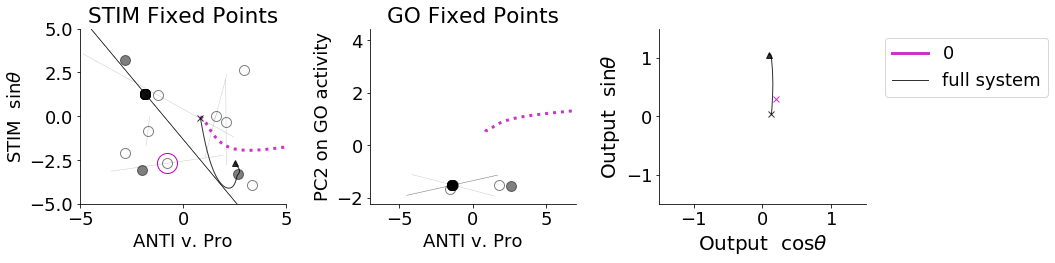

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

IndexError: index 22 is out of bounds for axis 0 with size 6

<Figure size 1080x288 with 0 Axes>

In [38]:
al = .8
from tools_lnd import add_ax_labels, out_axes
cmap_discrete = plt.get_cmap('Set1')

use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
epoch = 'stim1'
for t_num in range(0,80,8):
    fig = plt.figure(figsize=(15,4),tight_layout=True,facecolor='white')
    t_theta = (t_num/8)*36

    #STIMULUS PERIOD FIXED POINTS
    f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,epoch+'_'+str(t_theta)+'.npz')
    fp_struct = np.load(f)
    fp_inds = np.argsort([LA.norm(fp_struct['xstar'][s,:] - h_tf) for s in range(len(fp_struct['qstar']))])
    sorted_fps = fp_struct['xstar']
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])
    q_star = fp_struct['qstar'][:]
    FP_proj = np.dot(sorted_fps,D_use)

    #GO PERIOD FIXED POINTS
    f_go = os.path.join(m,'tf_fixed_pts_all_init',rule_master,'go1'+'_'+str(t_theta)+'.npz')
    fp_struct_go = np.load(f_go)
    sorted_fps_go = fp_struct_go['xstar']
    eig_decomps_go = comp_eig_decomp(fp_struct_go['J_xstar'][:,:,:])
    q_star_go = fp_struct_go['qstar'][:]
    D_go_fp,_,_ = make_FP_axs(f_go,m,rule_master,'go1',axs ='pca', clust = 'False')
    D_go_h,_,_ = make_FP_axs(f_go,m,rule_master,'go1',axs ='pca_h', clust = 'False')
#     D_go = D_go_h[:,:2]#np.concatenate((D_go_fp[:,:1],D_go_h[:,:1]),axis = 1)
    pc_use = 2
    D_go = np.concatenate((D_use[:,:1],D_go_h[:,(pc_use-1):pc_use]),axis = 1)
    FP_proj_go = np.dot(sorted_fps_go,D_go)

    s_set_labels = [0,1,2]
    s_set = [3,22,24]#[22,]#
    color_set = ['m',]#['r', 'm', 'b']#

    go_inds = get_T_inds(trial,'go1')
    x_t = np.matlib.repmat(trial.x[go_inds[0],t_num,:],len(go_inds),1)

    for si in range(len(s_set)):
        epoch = 'stim1'
        stim_inds = get_T_inds(trial,epoch)
        _, h_full = gen_X_from_model_dir(m,trial,d = [])
        h0 = h_full[:,t_num,stim_inds[0]-1]

        s = s_set[si]
        c = color_set[si]
        n_steps = 100#len(T_inds)

        h_stim = h0[np.newaxis,:]
        for t in range(n_steps):
            h_temp = np.zeros((len(s_set),n_rnn))
            del_h = h_stim[-1,:] - fp_struct['xstar'][s,:]
            h_temp = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
            h_stim = np.concatenate((h_stim,h_temp[np.newaxis,:]),axis = 0)

        #nonlinear system
        go_ic = h_stim[-1,:]
        h_t = vanilla_run_with_h0(params, x_t, go_ic, alpha)

        ax1 = plt.subplot(1,3,1)
        plot_FP(sorted_fps, D_use.T, eig_decomps)
#         plot_FP(sorted_fps_go, D_use.T, eig_decomps_go, q_star_go, 'g')
        plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)

        jitter = np.dot(h_stim,D_use)
        plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))

        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)

        ax2 = plt.subplot(1,3,2)
#         plot_FP(sorted_fps, D_go.T, eig_decomps, q_star, 'k')
        plot_FP(sorted_fps_go, D_go.T, eig_decomps_go)
    #     plt.plot(FP_proj_go[:,0],FP_proj_go[:,1],'.g',markersize = 10)

        jitter = np.dot(h_stim,D_go)
        plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))

        jitter = np.dot(h_t,D_go)
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
        lim = 7
        plt.xlim((-lim,lim))
        plt.xlim((-lim,lim))
        plt.xlabel(axes_label1)
        plt.ylabel('PC'+str(pc_use)+' on GO activity')
        plt.title('GO Fixed Points')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)  

        ax3 = plt.subplot(1,3,3)
        
#         jitter = np.dot(params,h_t.T)
#         plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al)
        
        jitter = out_affine(params, h_t.T)[1:,:].T
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(str(s_set_labels[si])))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
        plt.plot(jitter[0,0],jitter[0,1],'x',c=c,linewidth = 3,alpha = al)
    
    jitter = out_affine(params, h_full[:,t_num,stim_inds[-1]:])[1:,:].T
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 1,alpha = al,label = 'full system')
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = al)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    out_axes(ax3)

    ax1 = plt.subplot(1,3,1)
    jitter = np.dot(h_full[:,t_num,stim_inds[0]:].T,D_use)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 1,alpha = al,label = 'full system')
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = al)
    plt.ylim((-5,5))
    plt.xlim((-5,5))    
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)  
    plt.title('STIM Fixed Points')

    
    tit = 'single_FP_approx'

    if not os.path.exists(os.path.join(figpath,tit)):
        os.makedirs(os.path.join(figpath,tit))
    figname = tit+'_'+str(t_num)
    plt.savefig(os.path.join(figpath,tit,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,tit,figname+'.png'))
    plt.show()


IndexError: list index out of range

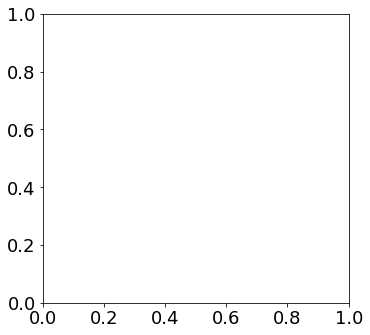

In [18]:
cmap = plt.get_cmap('rainbow')
cmap_discrete = plt.get_cmap('tab10')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)
s_set = [26,15,41,43,44,29]#29

fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

ax = plt.subplot(1,2,1)

for si in range(len(s_set)):
    s = s_set[si]
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c = cmap_discrete(si/len(s_set)))
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    
plt.ylim((-.5,.5))    
plt.xlim((.3,1.3))
plt.title(str(s)+ ' : ' + str(q_star[s]))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  

n_steps = len(T_inds)
ax = plt.subplot(1,2,2)

plot_FP(sorted_fps, D_use.T, eig_decomps,q_star, c)
for si in range(len(s_set)):
    s = s_set[si]
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c = cmap_discrete(si/len(s_set)),
             markerfacecolor = 'None',markersize = 20,linewidth = 7)

x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)

#     #nonlinear system
h0 = h[:,t_num,T_inds[0]]
h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
jitter = np.dot(h_t,D_use)
plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = .5)
plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = .5)

#     linear system
#     h0 = fp_struct['xstar'][s,:] + rand_step_coef*npr.randn(N)
h0 = h[:,t_num,T_inds[0]-1]
h_t = h0[np.newaxis,:]

for t in range(n_steps):
    h_temp = np.zeros((len(s_set),n_rnn))
    
    for si in range(len(s_set)):
        s = s_set[si]
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h_temp[si,:] = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h) - h_t[-1,:]
        
    h1 = h_t[-1,:]+ np.sum(h_temp,axis = 0)
    h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    
jitter = np.dot(h_t,D_use)
plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = .5)
plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)
plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)

plt.show()

In [ ]:
def plot_initXtasks(rule_ic_set, rule_in_set, c):
    
    output_labels = ['fixation',r' $\sin{\theta}$',r' $\cos{\theta}$']

    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        b = 0 #trial number for now
        h0 = h_all[rule_ic][t_ind,b,:]

        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            h_t = np.empty((n_steps,n_rnn))
            y_hat = np.empty((n_steps,n_output))
            x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
            h = h0
            for ti in range(t_end-t_start):
                h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                h_t[ti,:] = h
                y_hat[ti,:] = out_affine(params, h_t[ti,:])

            for out_ind in range(n_output):
                ax = plt.subplot(1,3,out_ind+1)
                plt.plot(y_hat[:,out_ind],c,label = rule_ic + ' ic', alpha = .2,linewidth = 2)
                plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':'+c,label = rule_in + ' target',linewidth = 2)
                plt.text(0,-.5,output_labels[out_ind])
                plt.ylim((-1.2,1.2))
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                if out_ind == 1:
                    plt.title(rule_ic_set['set_name']+' ic, '+ rule_in_set['set_name']+ ' input')
                    plt.legend(('ouput','target'),fontsize = 14)
                else:
                    ax.spines['left'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.get_xaxis().set_ticks([])
                    ax.get_yaxis().set_ticks([])

In [ ]:
fdgo_tasks = {'set_name':'DelayPro','set':['fdgo',]}
fdanti_tasks = {'set_name':'DelayAnti','set':['fdanti',]}
delay_tasks = {'set_name':['DelayPro','DelayAnti'],'set':['fdgo','fdanti']}

In [ ]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdgo_tasks, fdanti_tasks, 'g')
figname = 'fdgoIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdanti_tasks, fdgo_tasks, 'r')
figname = 'fdantiIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [ ]:
def quant_perf(rule_ic_set, rule_in_set):
    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        
        ri = 0
        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            n_trials = trial_all[rule_in].x.shape[1]
            
            y_locs = trial_all[rule_in].y_loc[t_start:,:]
            y_hat = np.empty((n_steps,n_trials,n_output))
            
            for b in range(n_trials):
                h0 = h_all[rule_ic][t_ind,0,:]
                h_t = np.empty((n_steps,n_rnn))
                x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
                h = h0
                for ti in range(t_end-t_start):
                    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                    h_t[ti,:] = h
                    y_hat[ti,b,:] = out_affine(params, h_t[ti,:])

            perf = get_perf(y_hat, y_locs)
            plt.plot(ri,np.mean(perf),'ok', alpha = .5)
            ri+=1
            
        plt.xticks(range(len(rule_in_set['set'])), rule_in_set['set'],rotation = 45)
        plt.ylim((-.1,1.1))
        plt.xlim((-.5,ri-.5))
        plt.title(rule_ic + ' ICs')

In [ ]:
fig = plt.figure(figsize=(6, 3))

# for model_n_temp in range(5):
model_n_temp = model_n
m_temp = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
h_all,trial_all,tasks_all = make_h_trial_rule(m_temp,mode = 'random',noise_on = True)

ax1 = plt.subplot(1,2,1)
quant_perf(fdgo_tasks, delay_tasks)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('performance')

ax2 = plt.subplot(1,2,2)
quant_perf(fdanti_tasks, delay_tasks)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

figname = 'quant_perf.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()